## Lab3 Goal 1.2 FNN Solution

Adds visualization of the dataset and information about training accuracy and loss to the Goal 1.1 FNN solution notebook


In [4]:
#only if you get restart karnell with plt.show
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [6]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(f"Size: Training data: {len(training_data)} Test data: {len(test_data)}")

Size: Training data: 60000 Test data: 10000


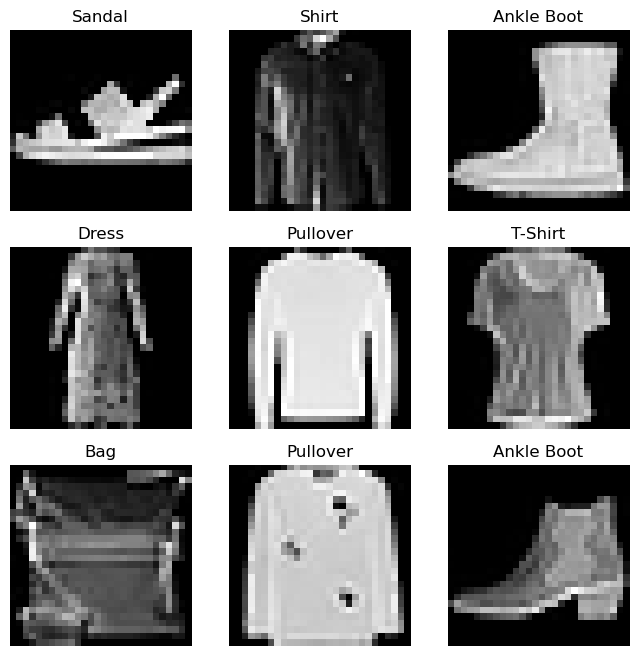

In [7]:
#visualise some of the images of the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [9]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_ret=[]
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_ret.append(loss)

    return loss_ret

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return [test_loss, correct]

In [13]:
epochs = 5
loss=[]
acc_test=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss.append(train(train_dataloader, model, loss_fn, optimizer))
    acc_test.append(test(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 2.300042  [   64/60000]
loss: 2.290911  [ 6464/60000]
loss: 2.270795  [12864/60000]
loss: 2.271795  [19264/60000]
loss: 2.259603  [25664/60000]
loss: 2.214748  [32064/60000]
loss: 2.238192  [38464/60000]
loss: 2.190486  [44864/60000]
loss: 2.191179  [51264/60000]
loss: 2.160304  [57664/60000]
Test Error: 
 Accuracy: 36.2%, Avg loss: 2.160108 

Epoch 2
-------------------------------
loss: 2.164415  [   64/60000]
loss: 2.160442  [ 6464/60000]
loss: 2.099701  [12864/60000]
loss: 2.121046  [19264/60000]
loss: 2.085260  [25664/60000]
loss: 2.003967  [32064/60000]
loss: 2.045806  [38464/60000]
loss: 1.956680  [44864/60000]
loss: 1.969672  [51264/60000]
loss: 1.896347  [57664/60000]
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.899210 

Epoch 3
-------------------------------
loss: 1.926820  [   64/60000]
loss: 1.902764  [ 6464/60000]
loss: 1.783094  [12864/60000]
loss: 1.828057  [19264/60000]
loss: 1.739553  [25664/60000]
loss: 1.667243  [32064/600

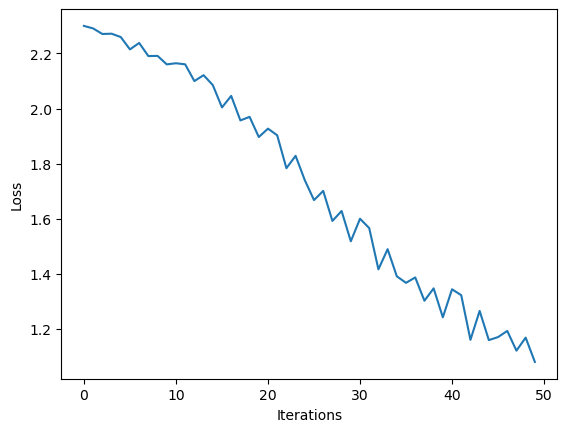

In [14]:
# plot of the loss with interaction (calculate for each batch of data)
flat_loss = [item for sublist in loss for item in sublist]
plt.plot(flat_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

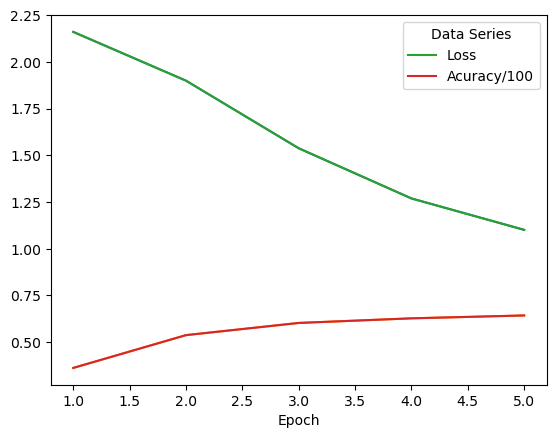

In [15]:
# plot achieved accuracy after each epoch
x = list(range(1,epochs+1))
plt.plot(x, acc_test)
plt.xlabel("Epoch")
plt.plot(x, acc_test, label=['Loss', 'Acuracy/100'])
plt.legend(loc='upper right', title='Data Series')
plt.show()

In [16]:
torch.save(model.state_dict(), "model_FNN.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [17]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model_FNN.pth", weights_only=True))

<All keys matched successfully>

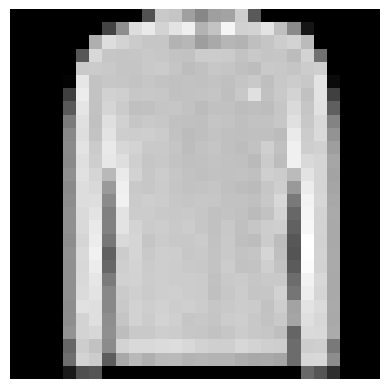

Image: "2127" Predicted: "Pullover", Actual: "Pullover"


In [35]:
model.eval()
n=torch.randint(len(test_data), size=(1,)).item()
img, label = test_data[n]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

with torch.no_grad():
    img = img.to(device)
    pred = model(img)
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[label]
    print(f'Image: "{n}" Predicted: "{predicted}", Actual: "{actual}"')